# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
#plt.style.use('fivethirtyeight') # For plots
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays
import random

Importing plotly failed. Interactive plots will not work.


In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
#data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')


In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


***Unimos los dataset para hacer un EDA más amplio.***

In [10]:
dataset = pd.concat([data_2019, data_2018, data_2017])
dataset

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [11]:
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')
dataset.drop(columns=['fecha','hora_fin'], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset.head()


,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2019,0,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,0,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,0,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,0,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,0,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


***Agregamos columnas a nuestro dataset para visualizar de mejor manera con gráficas.***

In [12]:
# data extraction
dataset['date'] = dataset.fecha
dataset['hora'] = dataset.date.dt.hour
dataset['dia'] = dataset.date.dt.day
dataset['semana'] = dataset.date.dt.isocalendar().week
dataset['mes'] = dataset.date.dt.month
dataset['año']=dataset.date.dt.year
dataset=dataset.drop(columns='fecha')
# adding new variable
dataset['cantidad_autos/forma_pago'] = dataset['cantidad_pasos']/len(dataset['forma_pago'].unique())


In [13]:
dataset.head(2)

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,date,hora,semana,mes,año,cantidad_autos/forma_pago
0,2019,0,1,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00,1,1,1,2019,2.444444
1,2019,0,1,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00,1,1,1,2019,0.666667


visualizamos como se comporta la cantidad de autos y a su vez la cantidad de autos de acuerdo a su forma de pago

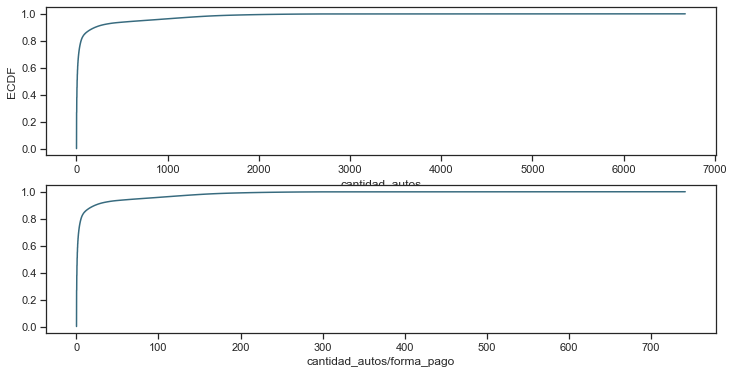

In [14]:
sns.set(style = "ticks")
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(211)
cdf = ECDF(dataset['cantidad_pasos'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('cantidad_autos'); plt.ylabel('ECDF');


# plot second ECDF  
plt.subplot(212)
cdf = ECDF(dataset['cantidad_autos/forma_pago'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('cantidad_autos/forma_pago');

Agrupamos en diferentes formas los datos.

In [15]:
dataset.groupby('estacion')['cantidad_pasos'].describe()

,count,mean,std,min,25%,50%,75%,max
estacion,,,,,,,,
Alberdi,303620.0,37.956511,82.835346,1.0,2.0,4.0,13.0,753.0
Alberti,132279.0,42.572147,85.336267,1.0,2.0,5.0,18.0,736.0
Avellaneda,972656.0,152.949845,424.497652,1.0,3.0,13.0,49.0,6677.0
Dellepiane,187600.0,156.159104,322.837770,1.0,6.0,16.0,74.0,2847.0
Dellepiane Centro,356885.0,87.670255,262.623091,1.0,2.0,7.0,24.0,2718.0
Dellepiane Liniers,353680.0,82.471666,238.966505,1.0,2.0,7.0,25.0,2483.0
Illia,752552.0,135.825550,386.818215,1.0,2.0,6.0,27.0,5330.0
PDB,40964.0,138.374573,173.697180,1.0,28.0,66.0,179.0,4928.0
Retiro,307528.0,16.004917,27.910906,1.0,2.0,5.0,18.0,428.0


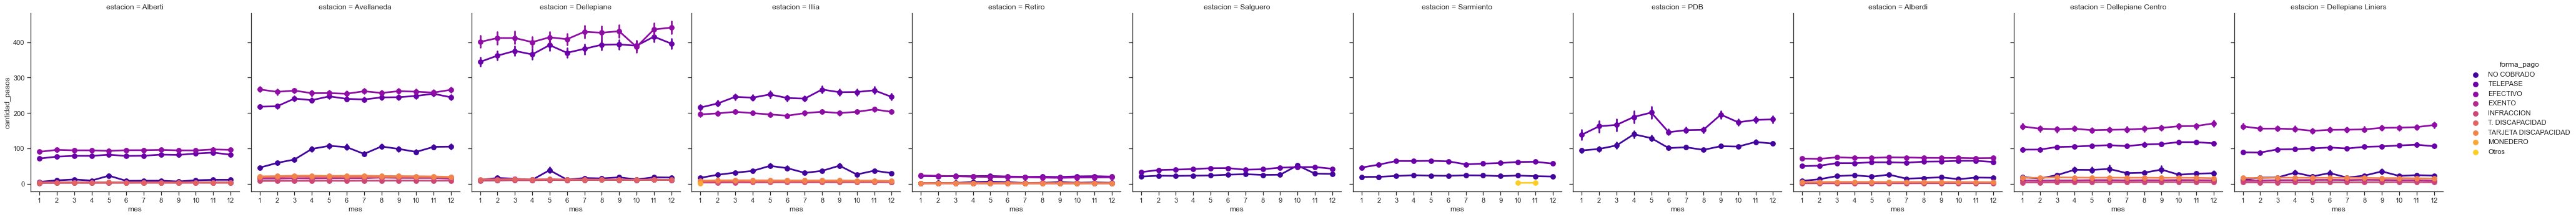

In [16]:
#Agrupamos para visualizar la cantidad de autos por mes de acuerdo a las estaciones correspondientes.
sns.factorplot(data = dataset, x = 'mes', y = "cantidad_pasos", 
               col = 'estacion', # per store type in cols
               palette = 'plasma',
               hue = 'forma_pago',
                # per promo in the store in rows
               color = c) 

Como podemos visualizar y en especifico en nuestra estación de interes, es que la disminución de pago en efectivo muestra una cLara tendencia similiar a la mayoria de formas de pago, por lo cual se concluye de primera instancia que no tiene una que ver con la otra.

In [17]:
dataset.groupby('forma_pago')['cantidad_pasos'].describe()

,count,mean,std,min,25%,50%,75%,max
forma_pago,,,,,,,,
EFECTIVO,1020176.0,179.723810,419.568937,1.0,3.0,12.0,80.0,3315.0
EXENTO,464708.0,9.121412,13.543584,1.0,2.0,5.0,10.0,856.0
INFRACCION,405034.0,6.044781,8.272486,1.0,1.0,3.0,7.0,84.0
MONEDERO,14.0,1.142857,0.363137,1.0,1.0,1.0,1.0,2.0
NO COBRADO,380450.0,45.173426,171.101769,1.0,2.0,7.0,29.0,6677.0
Otros,8.0,2.750000,2.659216,1.0,1.0,2.0,3.0,9.0
T. DISCAPACIDAD,76001.0,11.074788,12.560293,1.0,2.0,6.0,16.0,82.0
TARJETA DISCAPACIDAD,186454.0,14.087727,18.368333,1.0,1.0,6.0,20.0,152.0
TELEPASE,1027861.0,159.502090,387.791523,1.0,4.0,17.0,91.0,4077.0


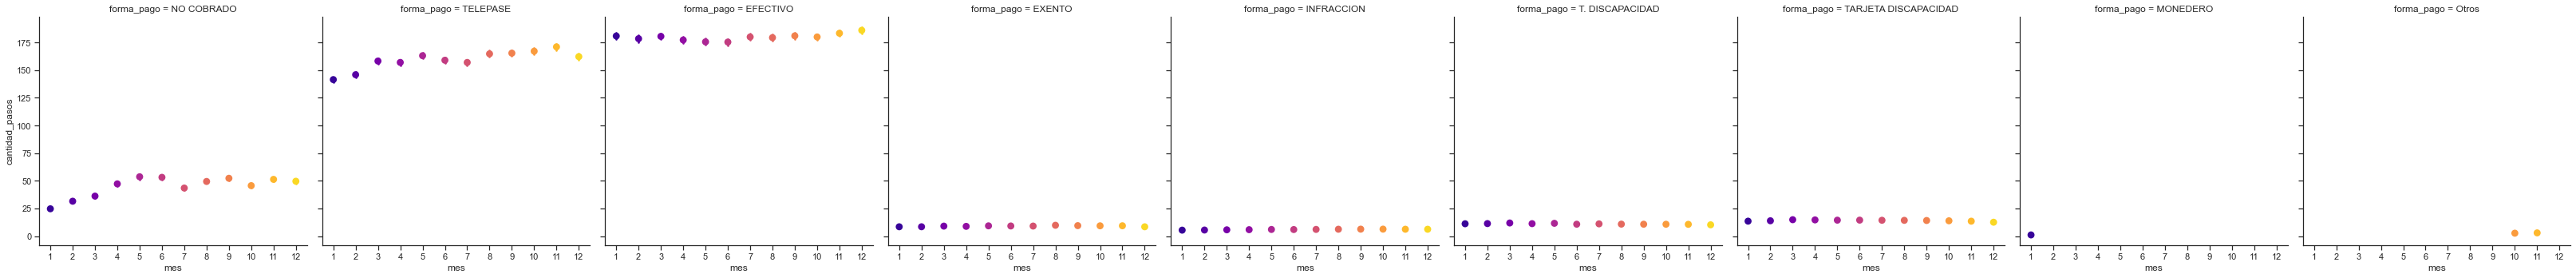

In [18]:
# sales trends
sns.factorplot(data = dataset, x = 'mes', y = "cantidad_pasos", 
               col = 'forma_pago', # per store type in cols
               palette = 'plasma',
               #hue = 'forma_pago',
               #row = 'sentido', # per promo in the store in rows
               color = c) 

De acuerdo a esta gráfica podemos concluir que el telepase ha incrementado mes a mes a lo largo del tiempo, sin embargo comparando con forma de pago efectivo no consideramos que sea el factor determinante de la disminución del mismo.

In [19]:
dataset.groupby('sentido')['cantidad_pasos'].describe()

,count,mean,std,min,25%,50%,75%,max
sentido,,,,,,,,
Centro,1549851.0,118.141467,348.232963,1.0,2.0,8.0,36.0,6677.0
Provincia,2010855.0,95.251043,297.225850,1.0,2.0,8.0,33.0,5722.0


Podemos concluir que como era de esperarse el mayor tránsito vehicular se genera hacia sentido centro

In [20]:
dataset.groupby('mes')['cantidad_pasos'].describe()

,count,mean,std,min,25%,50%,75%,max
mes,,,,,,,,
1,299651.0,99.376878,306.353001,1.0,2.0,8.0,33.0,3690.0
2,271191.0,100.708608,309.984906,1.0,2.0,8.0,32.0,6677.0
3,303769.0,104.166100,319.909472,1.0,2.0,8.0,34.0,3881.0
4,286725.0,103.768370,316.558904,1.0,2.0,8.0,33.0,3868.0
5,298155.0,105.680908,325.996575,1.0,2.0,8.0,34.0,5601.0
6,289397.0,104.347550,319.385367,1.0,2.0,8.0,34.0,5722.0
7,302361.0,104.765145,319.704593,1.0,2.0,8.0,34.0,3866.0
8,305032.0,106.867214,323.890190,1.0,2.0,8.0,35.0,4077.0
9,294020.0,107.666747,326.326017,1.0,2.0,8.0,35.0,4911.0


<Figure size 1008x576 with 0 Axes>

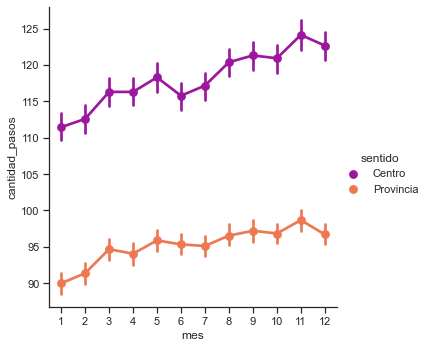

In [21]:
# sales trends
ax=plt.figure(figsize = (14, 8))
sns.factorplot(data = dataset, x = 'mes', y = "cantidad_pasos", 
               #col = 'sentido', # per store type in cols
               palette = 'plasma',
               hue='sentido',
                              #row = 'sentido', # per promo in the store in rows
               color = c,
                ax=ax)
#plt.figure(figsize = (12, 6))

***PRIMERAS CONCLUSIONES***

**De primera instancia podemos concluir, que la forma de pago que mas ha crecido es el telepase, que el tránsito vehicular principalmente como era de esperarse se mayor hacia el centro, la cantidad de flujo no ha crecido considerablemente a lo largo del tiempo, que el mayor flujo se da en noviembre y diciembre.**

##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


***Realizamos EDA para los datos con los que vamos a trabajar***

In [22]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [23]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [24]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [25]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [26]:
# data extraction
dataset['date'] = dataset.fecha
dataset['hora'] = dataset.date.dt.hour
dataset['dia'] = dataset.date.dt.day
dataset['semana'] = dataset.date.dt.isocalendar().week
dataset['mes'] = dataset.date.dt.month
dataset['año']=dataset.date.dt.year

In [27]:
#copiamos el dataset para nuestra gráficas de correlación
dataset_o=dataset.copy()
dataset_corr=dataset.copy()


hacemos one hot enconding de las variables categoricas para ver un mapa de correlación

In [28]:
df_dummies= pd.get_dummies(dataset_corr['tipo_vehiculo'])
df_dummies2= pd.get_dummies(dataset_corr['sentido'])
#del df_dummies[df_dummies.columns[-1]]
df_new = pd.concat([dataset_corr, df_dummies,df_dummies2], axis=1)
del df_new['tipo_vehiculo']
del df_new['sentido']
df_new['T_liviano']=df_new['Liviano']*df_new['cantidad_pasos']
df_new['T_pesado']=df_new['Pesado']*df_new['cantidad_pasos']
df_new['T_centro']=df_new['Centro']*df_new['cantidad_pasos']
df_new['T_provincia']=df_new['Provincia']*df_new['cantidad_pasos']
del df_new['Liviano']
del df_new['Pesado']
del df_new['Centro']
del df_new['Provincia']

df_new

,dia,cantidad_pasos,fecha,date,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
0,1,1,2017-01-01 00:00:00,2017-01-01 00:00:00,0,52,1,2017,0,1,0,1
1,1,9,2017-01-01 00:00:00,2017-01-01 00:00:00,0,52,1,2017,9,0,0,9
2,1,644,2017-01-01 00:00:00,2017-01-01 00:00:00,0,52,1,2017,644,0,0,644
3,1,6,2017-01-01 00:00:00,2017-01-01 00:00:00,0,52,1,2017,0,6,0,6
4,1,1,2017-01-01 00:00:00,2017-01-01 00:00:00,0,52,1,2017,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
238864,31,556,2019-12-31 22:00:00,2019-12-31 22:00:00,22,1,12,2019,556,0,0,556
238865,31,1,2019-12-31 22:00:00,2019-12-31 22:00:00,22,1,12,2019,0,1,0,1
238866,31,580,2019-12-31 22:00:00,2019-12-31 22:00:00,22,1,12,2019,580,0,580,0
238867,31,214,2019-12-31 23:00:00,2019-12-31 23:00:00,23,1,12,2019,214,0,214,0


In [29]:
dataset_o=df_new.copy()
dataset_o
d=dataset_o


In [30]:
dataset_diario=d.resample('D', on='fecha').sum()
dataset_diario
dataset_diario.describe()

,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,3420.386301,43712.859361,2590.400000,5701.134247,1405.461187,440153.474886,42318.291324,1394.568037,22563.804566,21149.054795
std,2502.554250,8192.736927,1103.492389,4151.069828,972.661811,183307.022589,7659.024427,636.171036,4416.781097,3934.687471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1369.000000,39061.500000,1104.000000,2296.000000,580.000000,193824.000000,38058.500000,876.000000,20059.000000,18852.500000
50%,2664.000000,43761.000000,3225.000000,4505.000000,1124.000000,546878.000000,42360.000000,1361.000000,22296.000000,21351.000000
75%,5389.500000,49498.000000,3449.500000,8912.000000,2192.000000,582913.000000,47626.000000,1909.000000,25705.500000,23915.000000
max,9960.000000,63127.000000,3959.000000,15657.000000,3720.000000,669644.000000,60748.000000,2983.000000,32669.000000,30458.000000


como vemos que la media de vehiculos diarios es de 43712 y solo el 25% es de aproximadamente 39061, haremos eliminación de autos con menos de 21000 de flujo diario 

In [31]:
mask=dataset_diario.cantidad_pasos<=21000
dataset_diario[mask]=np.nan
dataset_diario.describe()

,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
count,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,3442.801105,44021.025783,2608.764273,5736.430939,1414.268877,443187.839779,42616.438306,1404.587477,22734.507366,21286.518416
std,2495.726804,7444.254226,1087.997193,4141.568857,969.933668,180656.004285,6904.029048,628.600695,4005.103332,3597.963987
min,89.000000,21447.000000,794.000000,89.000000,75.000000,151425.000000,21221.000000,96.000000,10975.000000,5237.000000
25%,1396.250000,39139.500000,1104.000000,2310.000000,588.500000,193824.000000,38152.750000,880.250000,20104.500000,18916.250000
50%,2688.000000,43822.500000,3229.000000,4512.000000,1138.000000,548624.000000,42500.500000,1366.000000,22364.000000,21378.000000
75%,5399.250000,49548.750000,3451.750000,8974.500000,2192.000000,582913.000000,47653.250000,1911.750000,25729.000000,23935.750000
max,9960.000000,63127.000000,3959.000000,15657.000000,3720.000000,669644.000000,60748.000000,2983.000000,32669.000000,30458.000000


Realizamos una interpolación de esos valores que quedaron pendientes para un mejor desarrrollo de la predicción

In [32]:
dataset_diario.cantidad_pasos=dataset_diario.cantidad_pasos.interpolate()
dataset_diario.T_liviano=dataset_diario.T_liviano.interpolate()
dataset_diario.T_pesado=dataset_diario.T_pesado.interpolate()
dataset_diario.T_centro=dataset_diario.T_centro.interpolate()
dataset_diario.T_provincia=dataset_diario.T_provincia.interpolate()

In [33]:
#Resampleamos a hora para ver los gráficos
dataset_hora=dataset_diario.copy()
dataset_hora=dataset_diario.reset_index(level=['fecha'])
dataset_hora=dataset_hora.resample('H', on='fecha').sum()
dataset_hora

,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
fecha,,,,,,,,,,
2017-01-01 00:00:00,231.0,31183.0,2976.0,12012,231.0,465927.0,30641.0,542.0,17051.0,14132.0
2017-01-01 01:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-30 20:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-30 21:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-30 22:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


Gráficamos para visualizar el transito vehicular por hora a lo largo del tiempo

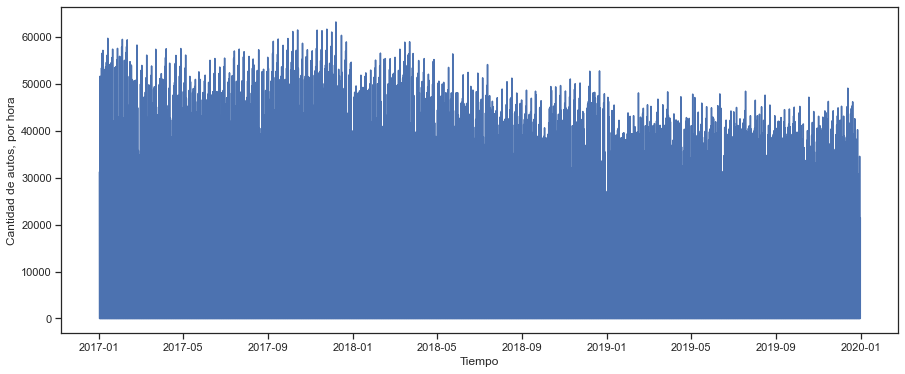

In [34]:
#Graficamos
plt.figure(figsize = (15,6))
plt.plot(dataset_hora.index, dataset_hora.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

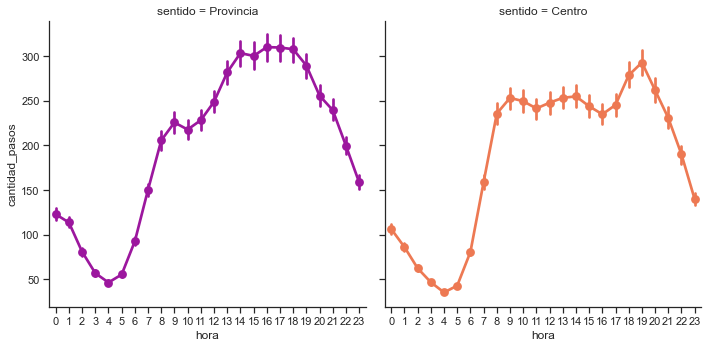

In [35]:
#Gráficas de manera mas precisa para una correcta visualización 
sns.factorplot(data = dataset, x = 'hora', y = "cantidad_pasos", 
               col = 'sentido',
               palette = 'plasma',
               hue = 'sentido',
              
               color = c) 

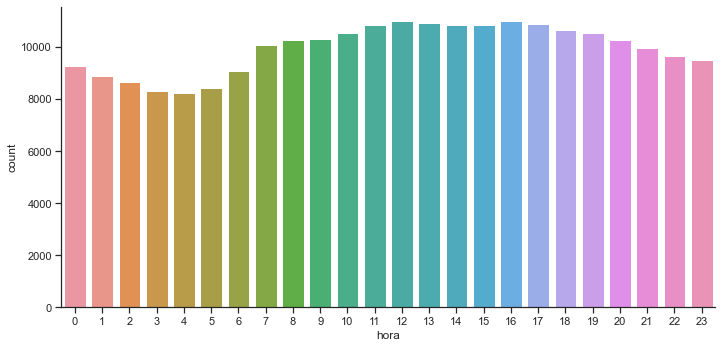

In [36]:
sns.catplot(x="hora", data=dataset, aspect=2,kind="count")

*Podemos ver que la mayor cantidad de flujo vehicular hacia provincia ocurre con picos a las 9 am y tiene su mayor crecimiento entre las 17 a 20 horas, y hacia centro como era de esperarse en las mañanas entre 8 y 9 am y un pico pronunciado aproximadamente a las 19 hras**

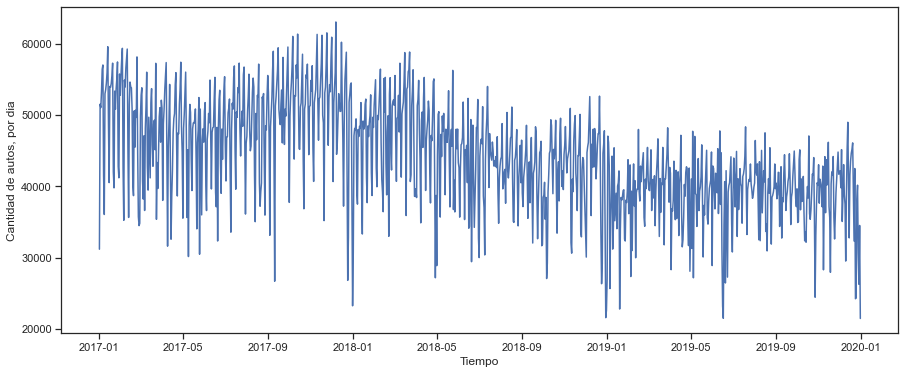

In [37]:
#Resampleamos por día
plt.figure(figsize = (15,6))
plt.plot(dataset_diario.index, dataset_diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

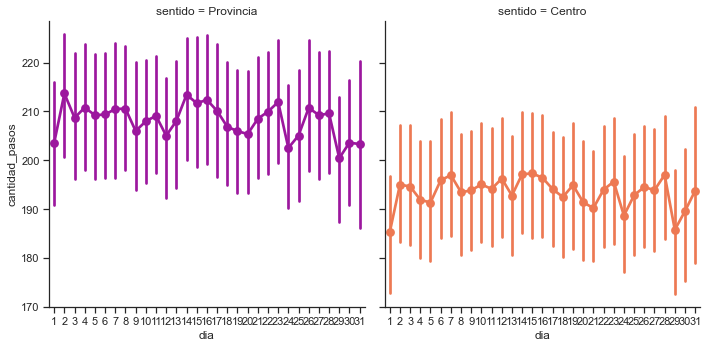

In [38]:
# Gráfica por sentido
sns.factorplot(data = dataset, x = 'dia', y = "cantidad_pasos", 
               col = 'sentido', # per store type in cols
               palette = 'plasma',
               hue = 'sentido',
               #row = 'sentido', # per promo in the store in rows
               color = c) 

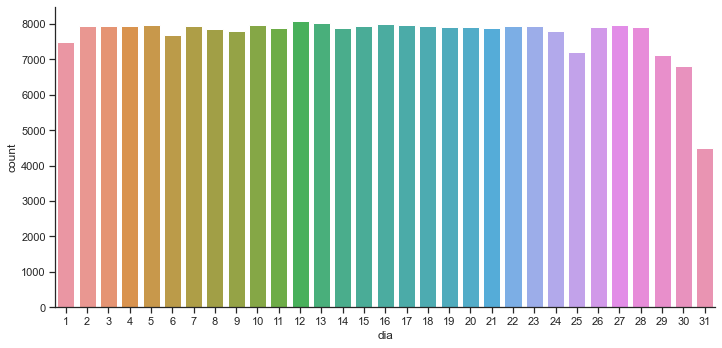

In [39]:
sns.catplot(x="dia", data=dataset, aspect=2,kind="count")

In [40]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
dataset_semanal=dataset_diario.copy()
dataset_semanal=dataset_semanal.reset_index(level=['fecha'])
semana = dataset_semanal.resample('W', on = 'fecha').sum()
print(semana.shape)
semana.head()

(158, 10)


,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
fecha,,,,,,,,,,
2017-01-01,231.0,31183.0,2976.0,12012,231.0,465927.0,30641.0,542.0,17051.0,14132.0
2017-01-08,10805.0,347212.0,26016.0,2179,2179.0,4395043.0,330163.0,17049.0,186964.0,160248.0
2017-01-15,26130.0,366413.0,25897.0,4362,2181.0,4399077.0,349123.0,17290.0,197873.0,168540.0
2017-01-22,41567.0,357215.0,26285.0,6576,2192.0,4421264.0,340440.0,16775.0,192292.0,164923.0
2017-01-29,57020.0,354581.0,26525.0,8780,2195.0,4427315.0,337684.0,16897.0,191140.0,163441.0


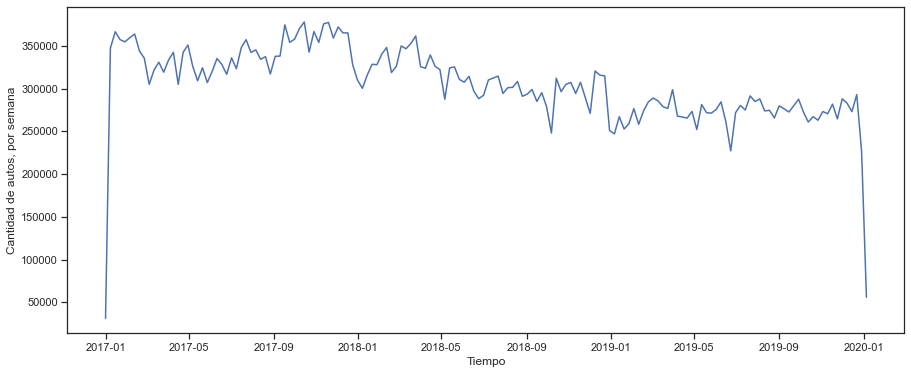

In [41]:
plt.figure(figsize = (15,6))
plt.plot(semana.index, semana.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [42]:
#Resampleamos nuestros datos para agrupar por mes
dataset_mes=dataset_diario.copy()
dataset_mes=dataset_mes.reset_index(level=['fecha'])
mes = dataset_mes.resample('M', on = 'fecha').sum()
print(mes.shape)
mes.head()

(36, 10)


,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
fecha,,,,,,,,,,
2017-01-31,155540.0,1565260.0,115552.0,37154,9627.0,19417659.0,1490993.0,74267.0,843430.0,721830.0
2017-02-28,123537.0,1363113.0,102467.0,58243,17204.0,17350234.0,1302618.0,60495.0,726712.0,636401.0
2017-03-31,146210.0,1451214.0,110300.0,100721,27471.0,18469669.0,1388940.0,62274.0,779606.0,671608.0
2017-04-30,133876.0,1429482.0,101514.0,130090,33816.0,17051718.0,1371187.0,58295.0,758427.5,671054.5
2017-05-31,141659.0,1407136.0,106585.0,175076,44340.0,17886756.0,1349105.0,58031.0,748827.0,658309.0


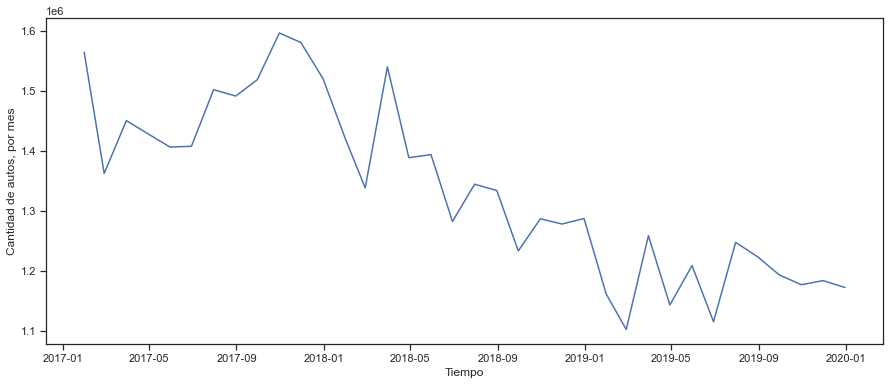

In [43]:
plt.figure(figsize = (15,6))
plt.plot(mes.index, mes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

En esta gráfica se puede ver claramente que hay una tendencia a la baja en la circulación de autos, cosa que en gráficas anteriores no se podia visualizar.
Hay que mencionar que en las primeras gráficas se muestra que la forma de pago efectivo con telepase no se relación entre si y que este último sea consecuencia de la disminución ya sea de numero de autos que transitan o en su defecto del registro de datos con este tipo de pagos.

A continuación vemos nuestra tabla de correlación

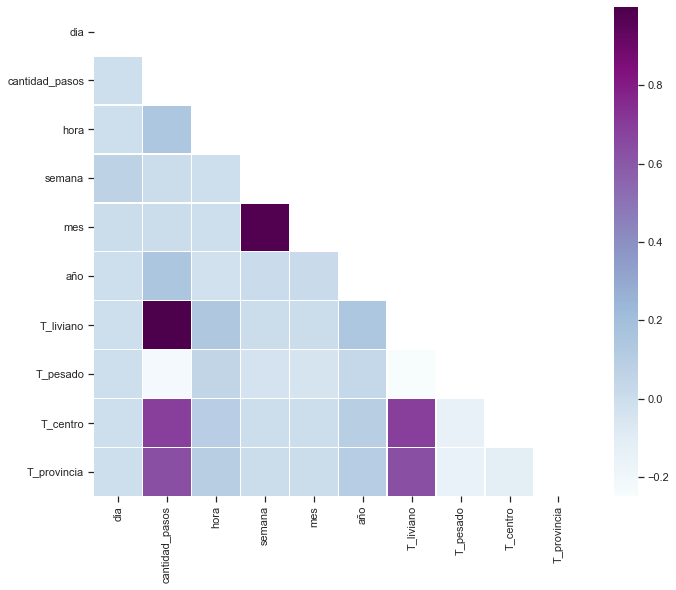

In [117]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = df_new.drop('date', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Podemos visualizar que los valores que mayor peso de correlación tiene son las variables, transito provincia y transito centro, asi como el tipo de vehiculo liviano muestra claraemente fuerte relación a la cantidad de autos que pasan, no obstante esto es de esperarse por que al final del día la suma de varias de estas variables dan el total de autos.

***DESCOMPOSICIÓN DE LA SERIE***

<AxesSubplot:xlabel='fecha'>

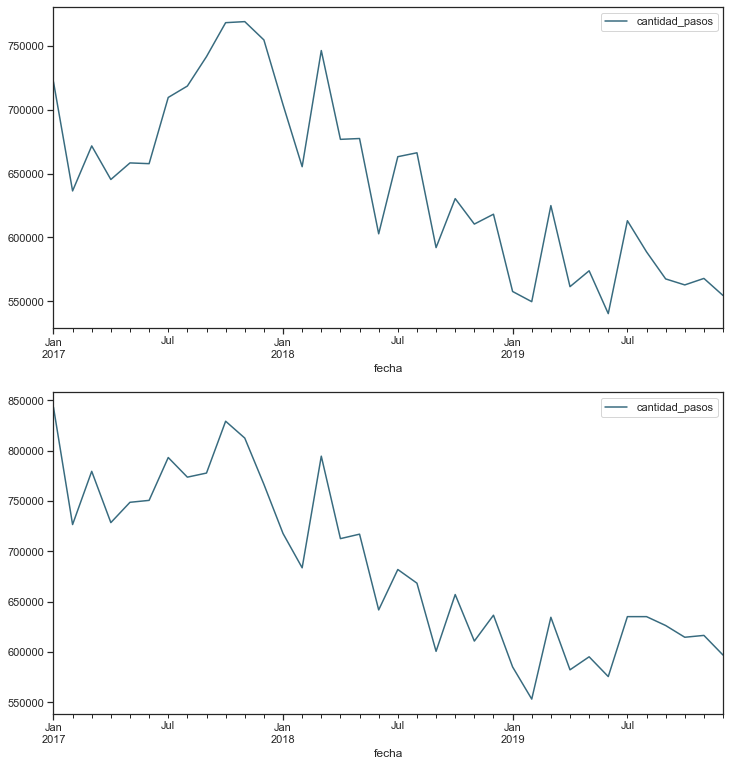

In [46]:
provincia = dataset[dataset.sentido =='Provincia'][['cantidad_pasos','fecha']]
centro = dataset[dataset.sentido == 'Centro'][['cantidad_pasos','fecha']]

f, (ax1, ax2) = plt.subplots(2, figsize = (12, 13))


provincia.resample('M', on='fecha').sum().plot(color = c, ax = ax1)
centro.resample('M', on='fecha').sum().plot(color = c, ax = ax2)


In [47]:
provincia=provincia.set_index('fecha')
centro=centro.set_index('fecha')

Realizamos una descomposición de la estacionalidad de la serie.

<AxesSubplot:xlabel='fecha'>

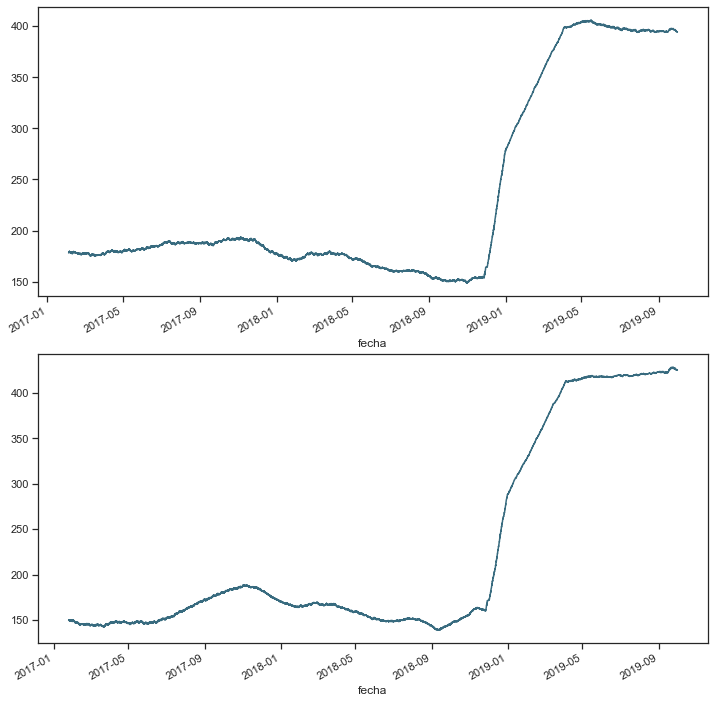

In [48]:
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 13))


descomposicion_provincia = seasonal_decompose(provincia, model = 'additive', freq = 8760)
descomposicion_provincia.trend.plot(color = c, ax = ax1)

descomposicion_centro = seasonal_decompose(centro, model = 'additive', freq = 8760)
descomposicion_centro.trend.plot(color = c, ax = ax2)



In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
series =provincia
result = seasonal_decompose(series, model='additive',freq=365)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

fecha
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
                       ..
2019-12-31 21:00:00   NaN
2019-12-31 21:00:00   NaN
2019-12-31 22:00:00   NaN
2019-12-31 22:00:00   NaN
2019-12-31 23:00:00   NaN
Name: trend, Length: 111173, dtype: float64
fecha
2017-01-01 00:00:00    -1.772253
2017-01-01 00:00:00    18.103694
2017-01-01 00:00:00    26.900657
2017-01-01 00:00:00    19.994627
2017-01-01 00:00:00    -6.500497
                         ...    
2019-12-31 21:00:00   -16.179580
2019-12-31 21:00:00   -45.803498
2019-12-31 22:00:00     2.400044
2019-12-31 22:00:00    45.205929
2019-12-31 23:00:00    29.435949
Name: seasonal, Length: 111173, dtype: float64
fecha
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
                       ..
2019-12-31 21:00:00   NaN
2019-12-31 21:00:00   NaN
2019-12-31 22:00:00   NaN
2019-12-

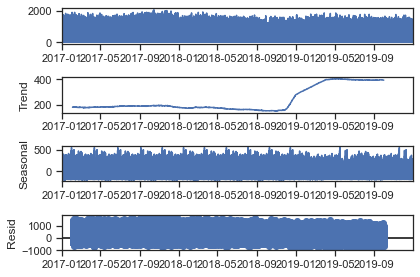

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = provincia
result = seasonal_decompose(series, model='additive',freq=8760)
result.plot()
pyplot.show()

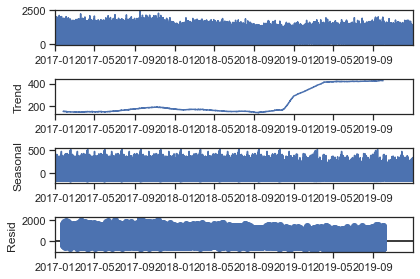

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = centro
result = seasonal_decompose(series, model='additive',freq=8760)
result.plot()
pyplot.show()

Visualizando los dos tipos de gráficos podemos concluir la tendencia es a la baja, no obstante presenta un aumento a inicios de 2019 , si bien en las gráficas iniciales se visualiza una caida pronunciada a finales de 2018, la lectura de tendencia es sensible a los cambios bruscos de tendencia, por ello muestra un brusco aumento., podemos conculir que la serie presenta una estacionalidad constante a lo largo del tiempo lo cual facilitara de mejor manera la predicción del mismo

In [52]:
from statsmodels.tsa.stattools import acf

nlags =  52
autocorr = acf(provincia.cantidad_pasos, nlags = nlags)
autocorr.shape

(53,)

Text(0.5, 0, 'lag')

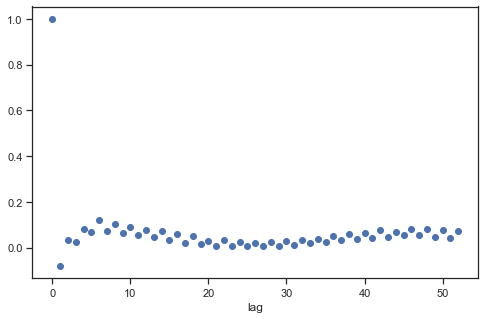

In [53]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

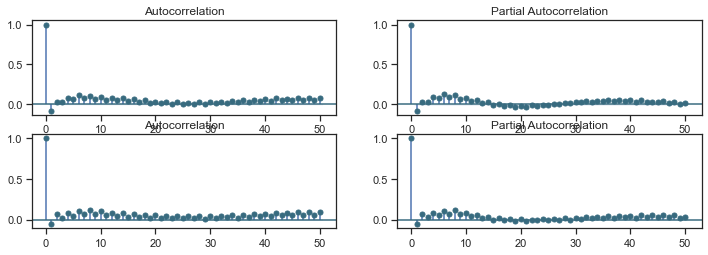

In [54]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(provincia, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(provincia, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(centro, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(centro, lags = 50, ax = plt.gca(), color = c)

plt.show()

Descompusimos nuestra serie, en los diversos componentes, hay que mencionar que en el primer trimestre de 2019 la tendencia cambia bruscamente, sin embargo no concretamos con mayor información de la causa, al igual podremos concluir que nuestra correlación nos marca que nuestros datos repiten el patrón cada 7 días de la misma manera, llegando asi a poder concluir que podremos tener predicciones con buenos resultados.

**BENCHMARK**

Utilizaremos un modelo de randomForest para nuestro modelo benchmark e intentaremos mejorar nuestro performance con el algoritmo de prophet

In [55]:
df=dataset_diario.copy()

In [56]:
senial = df.cantidad_pasos
senial.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [139]:
look_back = 52*2 # usamos dos anios de datos para predecir el valor siguiente

In [140]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(990, 104) (990,)


In [141]:
for i in range(X.shape[0]):
    #X[i,:] = senial.values.iloc[i:i+look_back]
    #y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [142]:
N_train = 10*52 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 4*52 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(416, 104) (416,)
(208, 104) (208,)


In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, oob_score=True,random_state=42, n_jobs = -1).fit(X_train,y_train)

In [144]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

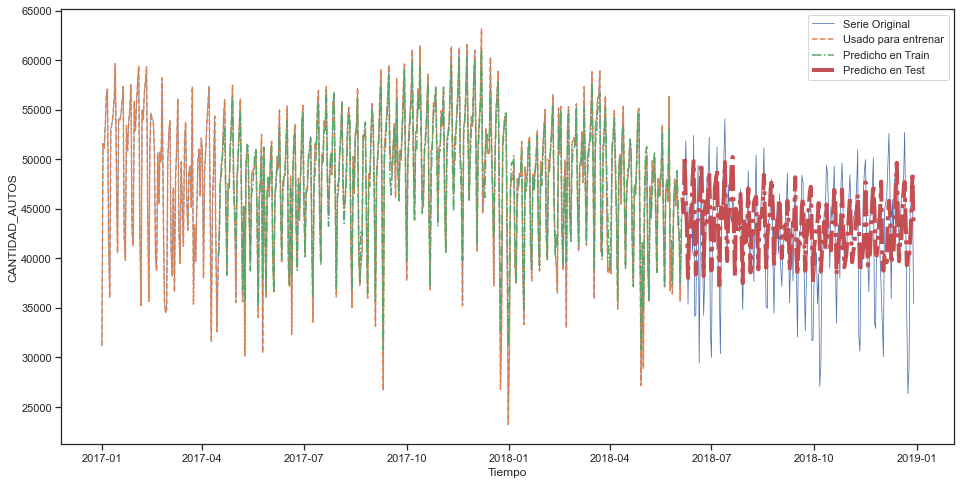

In [145]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('CANTIDAD_AUTOS')
plt.show()

Para este tipo de problema de forecast utilizaremos una metrica llamada MAPE, que nos generaliza los errores de manera más uniforme que RMSE, no obstante tomaremos el RMSE de nuestro modelo benchmark solo de manera representativa.

In [146]:
#Creamos nuestra funcion para sacar nuestra métrica MAPE
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [147]:
RMSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(RMSE))

RMSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(RMSE))

Error en Train: 1734.6093225954646
Error en Test: 4461.9389909409165


In [148]:
MAPE_train_R=(mean_absolute_percentage_error(y_train,y_train_pred))
MAPE_test_R=(mean_absolute_percentage_error(y_test,y_test_pred))
print(f'MAPE EN TRAIN ES:{MAPE_train_R}')
print(f'MAPE EN TEST ES:{MAPE_test_R}')

MAPE EN TRAIN ES:2.764184326568498
MAPE EN TEST ES:8.697439342844408


utilizamos tecnica multi-step

In [149]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

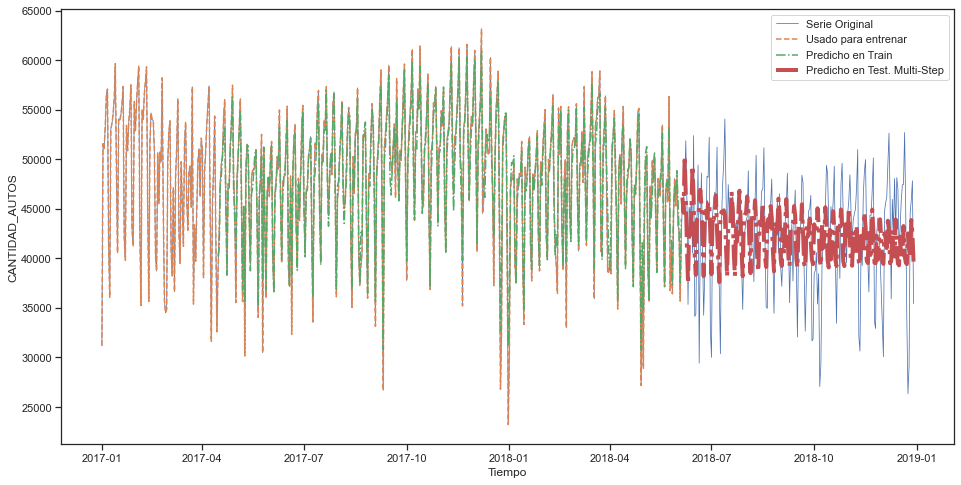

In [150]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('CANTIDAD_AUTOS')
plt.show()

In [69]:
RMSE_2 = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(RMSE_2))

Error en Test: 4965.615928711761


In [70]:
mean_absolute_percentage_error(y_test,y_ms_test_pred)

11.951006768102104

Como podemos concluir, la estrategia multi step empeoro nuestro resultado, sin embargo nuestro modelo tiene una performance bastante buena y aceptable, veremos a continuación que tanto nos puede aportar el modelo prophet


***MODELO PROPHET***

In [71]:
df=dataset_diario
df

,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
fecha,,,,,,,,,,
2017-01-01,231.0,31183.0,2976.0,12012,231.0,465927.0,30641.0,542.0,17051.0,14132.0
2017-01-02,632.0,51568.0,3713.0,316,316.0,637372.0,48979.0,2589.0,27825.0,23743.0
2017-01-03,921.0,51093.0,3573.0,307,307.0,619219.0,48322.0,2771.0,27567.0,23526.0
2017-01-04,1284.0,53332.0,3909.0,321,321.0,647457.0,50581.0,2751.0,28949.0,24383.0
2017-01-05,1590.0,56486.0,3820.0,318,318.0,641406.0,53622.0,2864.0,30820.0,25666.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2592.0,40182.0,1104.0,4992,1152.0,193824.0,39408.0,774.0,21187.0,18995.0
2019-12-28,2688.0,30681.0,1104.0,4992,1152.0,193824.0,30245.0,436.0,15995.0,14686.0
2019-12-29,2784.0,26259.0,1104.0,4992,1152.0,193824.0,25995.0,264.0,13715.0,12544.0


reseteamos nuestro index

In [72]:
df=df.reset_index(level=['fecha'])
df

,fecha,dia,cantidad_pasos,hora,semana,mes,año,T_liviano,T_pesado,T_centro,T_provincia
0,2017-01-01,231.0,31183.0,2976.0,12012,231.0,465927.0,30641.0,542.0,17051.0,14132.0
1,2017-01-02,632.0,51568.0,3713.0,316,316.0,637372.0,48979.0,2589.0,27825.0,23743.0
2,2017-01-03,921.0,51093.0,3573.0,307,307.0,619219.0,48322.0,2771.0,27567.0,23526.0
3,2017-01-04,1284.0,53332.0,3909.0,321,321.0,647457.0,50581.0,2751.0,28949.0,24383.0
4,2017-01-05,1590.0,56486.0,3820.0,318,318.0,641406.0,53622.0,2864.0,30820.0,25666.0
...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,2592.0,40182.0,1104.0,4992,1152.0,193824.0,39408.0,774.0,21187.0,18995.0
1091,2019-12-28,2688.0,30681.0,1104.0,4992,1152.0,193824.0,30245.0,436.0,15995.0,14686.0
1092,2019-12-29,2784.0,26259.0,1104.0,4992,1152.0,193824.0,25995.0,264.0,13715.0,12544.0
1093,2019-12-30,2850.0,34523.0,1101.0,95,1140.0,191805.0,33862.0,661.0,18599.0,15924.0


In [73]:
#llamamos las columnas que utilizaremos para el entrenamiento
df=df[['fecha','cantidad_pasos','T_liviano']]
df

,fecha,cantidad_pasos,T_liviano
0,2017-01-01,31183.0,30641.0
1,2017-01-02,51568.0,48979.0
2,2017-01-03,51093.0,48322.0
3,2017-01-04,53332.0,50581.0
4,2017-01-05,56486.0,53622.0
...,...,...,...
1090,2019-12-27,40182.0,39408.0
1091,2019-12-28,30681.0,30245.0
1092,2019-12-29,26259.0,25995.0
1093,2019-12-30,34523.0,33862.0


In [74]:
#hacemos una copia para poder hacer visualizacion de como se distribuye nuestro set de entrenamiento y testeo
df2=df.copy()

In [75]:
#Mandamos a llamar solo las columnas que ocuparemos para visualizar de manera correcta 
df2=df2[['fecha','cantidad_pasos']]

In [76]:
split_date = '01-Jun-2019'
pjme_train = df2.loc[df.fecha <= split_date].copy()
pjme_test = df2.loc[df.fecha > split_date].copy()

In [77]:
pjme_train=pjme_train.resample('D', on='fecha').sum()
pjme_test=pjme_test.resample('D', on='fecha').sum()

Gráficamos como se veria nuestro dataset de entrenamiento y testeo basandonos solamente en la cantidad de autos sin otras variables añadidas

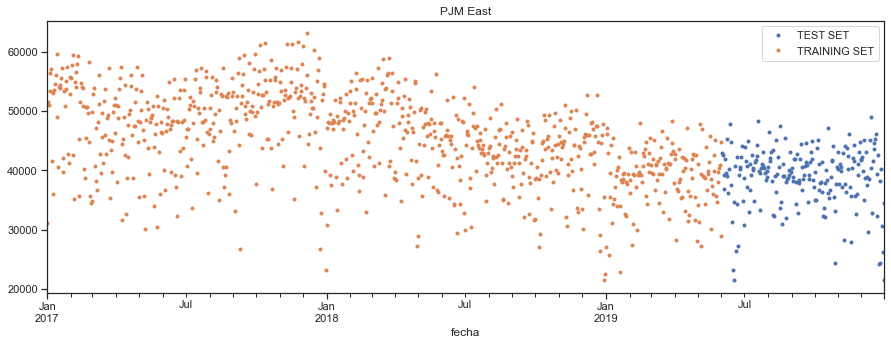

In [78]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'cantidad_pasos': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'cantidad_pasos': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

Como ya visualizamos los datos como se ve nuestro training set y nuestro test set, regresamos a llamar todas nuestras variables.

In [79]:
split_date = '01-Jun-2019'
pjme_train = df.loc[df.fecha <= split_date].copy()
pjme_test = df.loc[df.fecha > split_date].copy()

In [80]:
pjme_train=pjme_train.resample('D', on='fecha').sum()
pjme_test=pjme_test.resample('D', on='fecha').sum()

In [81]:
#pjme_train['ds'] = pjme_train['fecha']
pjme_test=pjme_test.reset_index(level=['fecha'])
pjme_test['ds'] = pjme_test['fecha']
pjme_test['y'] = pjme_test['cantidad_pasos']
pjme_train=pjme_train.reset_index(level=['fecha'])
pjme_train['ds'] = pjme_train['fecha']
pjme_train['y'] = pjme_train['cantidad_pasos']
pjme_train

,fecha,cantidad_pasos,T_liviano,ds,y
0,2017-01-01,31183.0,30641.0,2017-01-01,31183.0
1,2017-01-02,51568.0,48979.0,2017-01-02,51568.0
2,2017-01-03,51093.0,48322.0,2017-01-03,51093.0
3,2017-01-04,53332.0,50581.0,2017-01-04,53332.0
4,2017-01-05,56486.0,53622.0,2017-01-05,56486.0
...,...,...,...,...,...
877,2019-05-28,39739.0,38740.0,2019-05-28,39739.0
878,2019-05-29,40353.5,39368.5,2019-05-29,40353.5
879,2019-05-30,40968.0,39997.0,2019-05-30,40968.0
880,2019-05-31,44849.0,43739.0,2019-05-31,44849.0


In [82]:
pjme_train=pjme_train.resample('D', on='ds').sum()
pjme_test=pjme_test.resample('D', on='ds').sum()

In [83]:
pjme_train=pjme_train.reset_index(level=['ds'])
pjme_test=pjme_test.reset_index(level=['ds'])

En esta parte agradecemos a la página https://www.lanacion.com.ar/ por los datos fiables de las vacaciones en argentina, si bien no obtuvimos de todos los años de entrenamiento, consideramos que los años utilizados fueron de gran utilidad. A continuación se presenta solo el dataset con los datos ya que no es objeto de estudio no se especifican ni estrategias ni elementos de la misma.

In [84]:
holidays= pd.read_csv('holidays.csv')
holidays=holidays.sort_values(by='ds')

In [85]:
holidays

,Unnamed: 0,holiday,ds
0,0,school_holiday,2018-01-01
1,1,school_holiday,2018-02-12
2,2,school_holiday,2018-02-13
3,3,school_holiday,2018-03-24
4,4,school_holiday,2018-03-29
...,...,...,...
43,43,school_holiday,2019-10-12
62,62,school_holiday,2019-10-14
38,38,school_holiday,2019-11-18
39,39,school_holiday,2019-12-08


Entrenaremos un primer modelo de prophet sin optimización de hiperparametros para ver como performance nuestros datos y modelo.

In [86]:
m=Prophet(daily_seasonality=True)
m.fit(pjme_train)

In [87]:
pjme_train_fcst = m.predict(pjme_train)
pjme_test_fcst = m.predict(pjme_test)

In [88]:
MAPE_train = mean_absolute_percentage_error(pjme_train.cantidad_pasos,pjme_train_fcst.yhat)
MAPE_test = mean_absolute_percentage_error(pjme_test.cantidad_pasos,pjme_test_fcst.yhat)
print(f'errror en train: {MAPE_train}')
print(f'errror en train: {MAPE_test}')

errror en train: 7.970063560909272
errror en train: 10.129164698881327


Como vemos nuestro tiende a hacer overfiting y un error más alto que nuestro modelo benchmark, procederemos a optimización de hiperparametros

In [89]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.02,0.05],
              'holidays_prior_scale':[20],
              'n_changepoints' : [25,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 8


In [90]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = 30,
                         holidays=holidays, 
                         interval_width=0.95)
    #train_model.add_seasonality(name='quarterly',
                                    #period=365.25 / 4 ,fourier_order=15)
    
    train_model.add_seasonality (name = 'year', period = 50, fourier_order = 3, prior_scale = 0.002)
    #train_model.add_regressor('T_liviano')
    train_model.fit(pjme_train)
    train_forecast = train_model.predict(pjme_train)
    test_forecast = train_model.predict(pjme_test)
    
   
    MAPE = mean_absolute_percentage_error(pjme_test.cantidad_pasos,test_forecast.yhat)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 20, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.175523768997746
{'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 20, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.02851957447696
{'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.150822092780828
{'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 20, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.052268646383173
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 20, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MA

In [91]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,9.798669,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,10.056106,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,10.177587,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,10.199768,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,13.028520,"{'changepoint_prior_scale': 0.02, 'holidays_pr..."


In [92]:
#lo asignamos en una variable para si se modifica los valores, no estar cargando datos manualmente
r=parameters['Parameters'][0]
r

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 20,
 'n_changepoints': 25,
 'seasonality_mode': 'additive'}

In [93]:
m = Prophet(seasonality_mode=r['seasonality_mode'],
            changepoint_prior_scale=r['changepoint_prior_scale'],interval_width=0.95, 
            yearly_seasonality=30,holidays=holidays,daily_seasonality=True,n_changepoints=r['n_changepoints'],
            weekly_seasonality=True,holidays_prior_scale=r['holidays_prior_scale'])
#m = Prophet(interval_width=0.95,holidays=holidays,daily_seasonality=True,weekly_seasonality=True,holidays_prior_scale=20)
#m.add_seasonality(name='quarterly',period=365.25 / 4 ,fourier_order=15)
m.add_seasonality (name = 'year', period = 50, fourier_order = 3, prior_scale = 0.002)
#m.add_regressor('T_liviano')
m.fit(pjme_train)

In [94]:
forecast = m.predict(pjme_test.drop(columns="y"))
future = m.make_future_dataframe(periods=24 , freq='D')
future.tail()

,ds
901,2019-06-21
902,2019-06-22
903,2019-06-23
904,2019-06-24
905,2019-06-25


In [95]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#forecast.tail()

,ds,yhat,yhat_lower,yhat_upper
901,2019-06-21,39516.312456,30646.064993,48165.829630
902,2019-06-22,31336.148993,22781.048688,40536.697945
903,2019-06-23,27094.289369,18768.002811,35816.326878
904,2019-06-24,34586.714466,26412.407822,42793.067746
905,2019-06-25,36514.127673,28391.689669,45050.065201


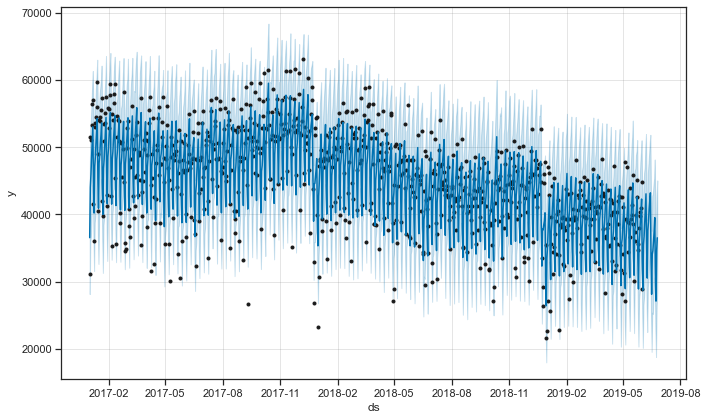

In [96]:
#Visualizamos nuestros resultados del entrenamiento
fig1 = m.plot(forecast)

In [97]:
#pjme_test_fcst = m.predict(df=pjme_test.reset_index() \
                                  # .rename(columns={'fecha':'ds'}))

In [98]:
pjme_train_fcst = m.predict(pjme_train)
pjme_test_fcst = m.predict(pjme_test)

In [99]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-02,24480.224832,20035.667840,37089.066786,24480.224832,24480.224832,4237.698292,4237.698292,4237.698292,14386.882867,...,-18.766358,-18.766358,-18.766358,-2352.796444,-2352.796444,-2352.796444,0.0,0.0,0.0,28717.923124
1,2019-06-03,24472.718255,27138.427620,43547.256516,24472.718255,24473.192634,11003.916915,11003.916915,11003.916915,14386.882867,...,-25.418806,-25.418806,-25.418806,-2366.628693,-2366.628693,-2366.628693,0.0,0.0,0.0,35476.635170
2,2019-06-04,24465.211677,27788.513491,45409.169779,24464.156247,24466.621739,12276.399207,12276.399207,12276.399207,14386.882867,...,-31.107853,-31.107853,-31.107853,-2292.764643,-2292.764643,-2292.764643,0.0,0.0,0.0,36741.610884
3,2019-06-05,24457.705100,30628.746566,47417.275071,24455.213350,24461.460902,14411.248934,14411.248934,14411.248934,14386.882867,...,-36.072658,-36.072658,-36.072658,-2100.537726,-2100.537726,-2100.537726,0.0,0.0,0.0,38868.954033
4,2019-06-06,24450.198522,32261.955559,49304.776293,24445.583420,24456.027422,16265.214610,16265.214610,16265.214610,14386.882867,...,-40.539669,-40.539669,-40.539669,-1783.477878,-1783.477878,-1783.477878,0.0,0.0,0.0,40715.413132


A continuación visualizamos nuestras primeras predicciones del ultimo trimestre de 2019

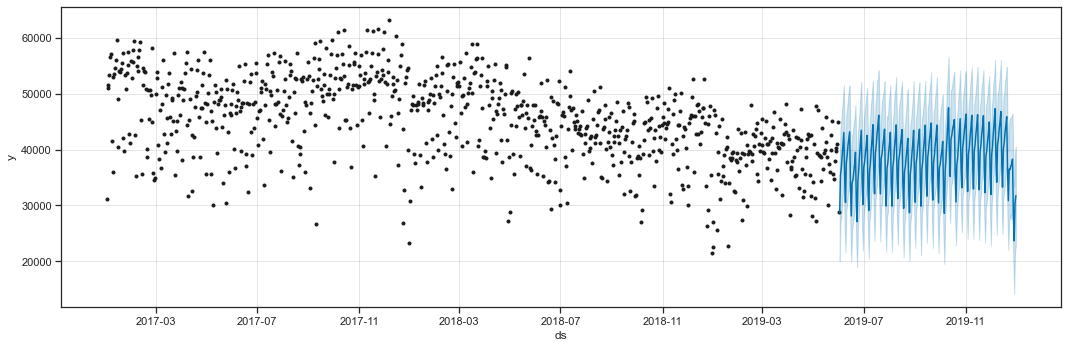

In [100]:
# Visualizamos nuestro dataset con predicciones del ulitmo trimestre de 2019

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

In [101]:
MAPE_train_P = mean_absolute_percentage_error(pjme_train.cantidad_pasos,pjme_train_fcst.yhat)
MAPE_test_P = mean_absolute_percentage_error(pjme_test.cantidad_pasos,pjme_test_fcst.yhat)
print(f'errror en train: {MAPE_train_P}')
print(f'errror en train: {MAPE_test_P}')


errror en train: 7.73296639317635
errror en train: 9.798669287109458


Gráficamos con los valores reales

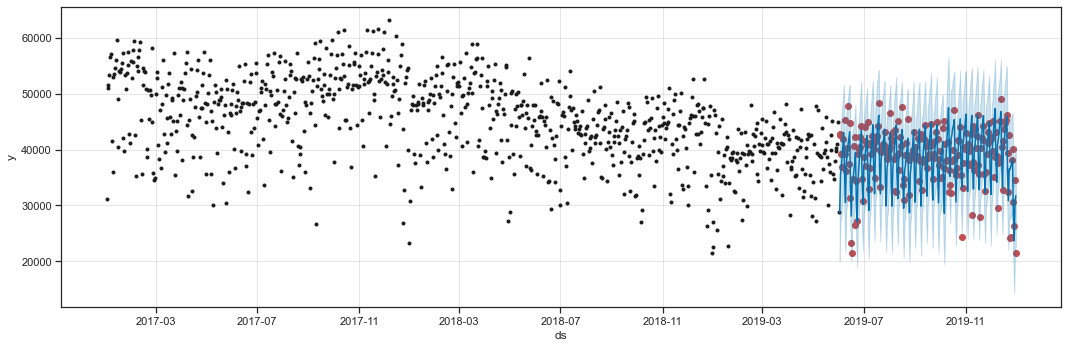

In [102]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.ds, pjme_test['cantidad_pasos'], color='r')
fig = m.plot(pjme_test_fcst, ax=ax)

Realizamos un cross validation

In [103]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-01-02 00:00:00 and 2018-06-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-03,45036.744630,37711.689004,52756.689001,48162.0,2018-01-02
1,2018-01-04,46663.841004,38932.391450,54528.127414,47953.0,2018-01-02
2,2018-01-05,48928.901992,41292.385978,55880.433053,49505.0,2018-01-02
3,2018-01-06,39453.905133,31729.082892,46564.936050,39235.0,2018-01-02
4,2018-01-07,33393.196530,25849.748878,40667.785411,37522.0,2018-01-02


Analizamos nuestras metricas.

In [104]:
df_p = performance_metrics(df_cv)
df_p.head(100)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,3.277886e+07,5725.282581,4407.462515,0.099439,0.071082,0.826484
1,38 days,3.442131e+07,5866.967604,4534.050794,0.102947,0.075508,0.812785
2,39 days,3.473808e+07,5893.902207,4583.073950,0.104015,0.076322,0.808219
3,40 days,3.515490e+07,5929.156964,4637.898233,0.105123,0.078991,0.801370
4,41 days,3.545941e+07,5954.780063,4673.070126,0.105749,0.080112,0.799087
...,...,...,...,...,...,...,...
95,132 days,6.747444e+07,8214.282456,6721.387613,0.162790,0.137153,0.627854
96,133 days,6.900744e+07,8307.071600,6815.960385,0.165057,0.139561,0.616438
97,134 days,6.766659e+07,8225.970756,6733.270931,0.162724,0.137153,0.618721
98,135 days,6.654225e+07,8157.343555,6662.571483,0.160659,0.137153,0.618721


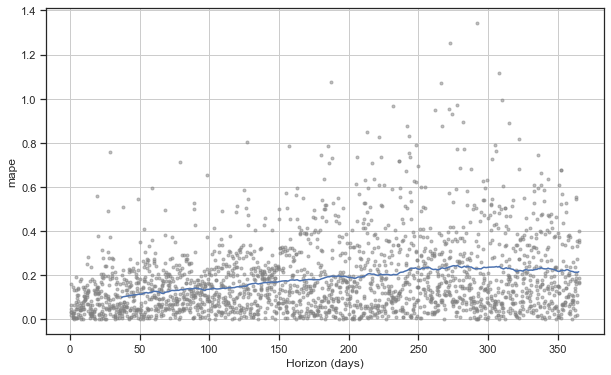

In [105]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

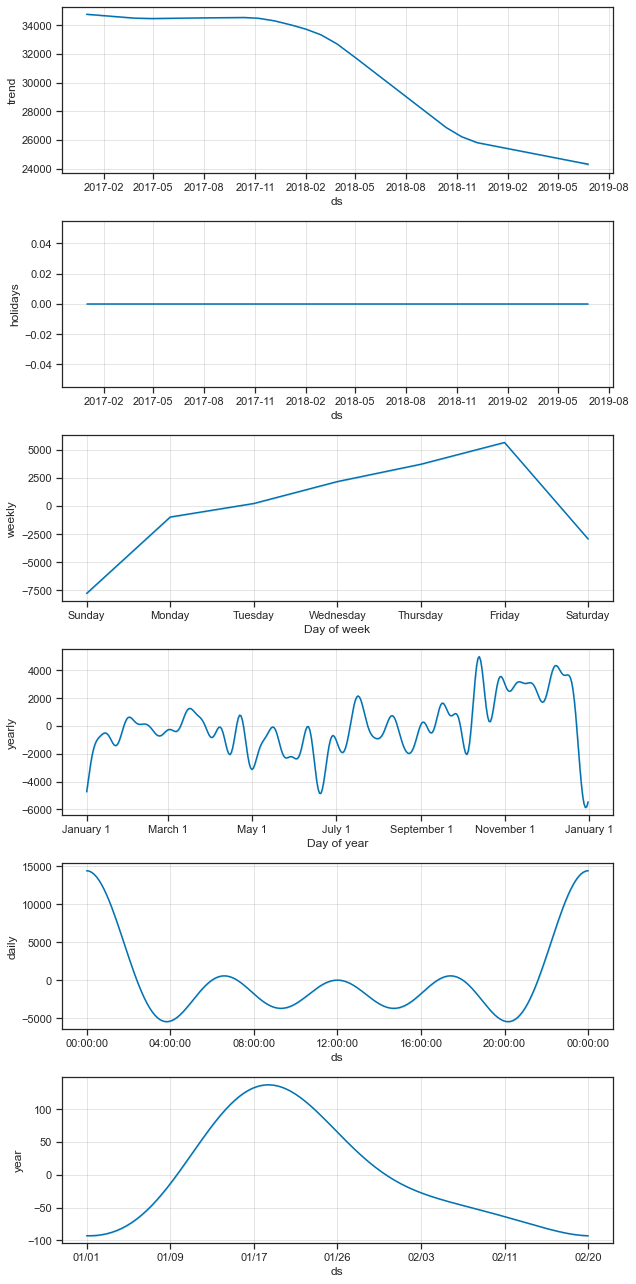

In [106]:
fig2 = m.plot_components(forecast)

Gráficamos nuestros puntos de cambio de tendencia.

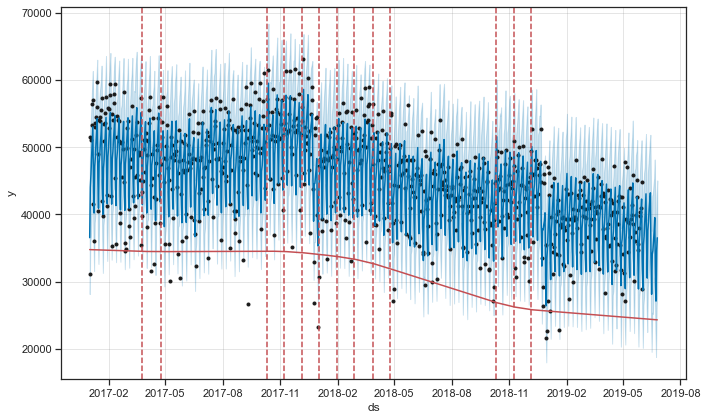

In [107]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Procedemos a predecir, el último trimestre de 2019 y el primer trimestre de 2020

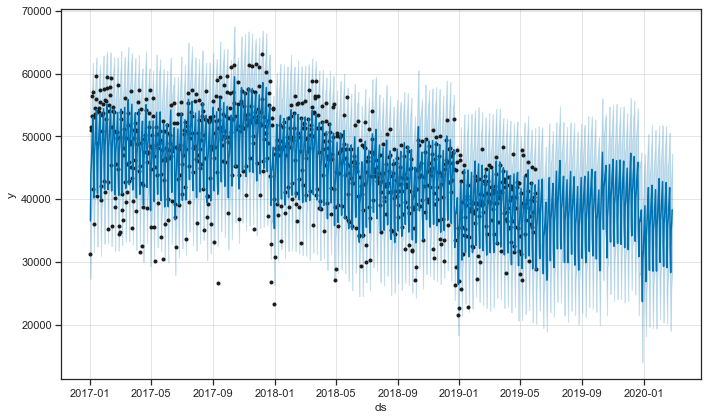

In [108]:
#m = Prophet(n_changepoints=3).fit(pjme_train)
future = m.make_future_dataframe(periods=270, freq='D')
forecast = m.predict(future)
fig = m.plot(m.predict(future))

Ahora visualizamos una proyeccion a 1 año

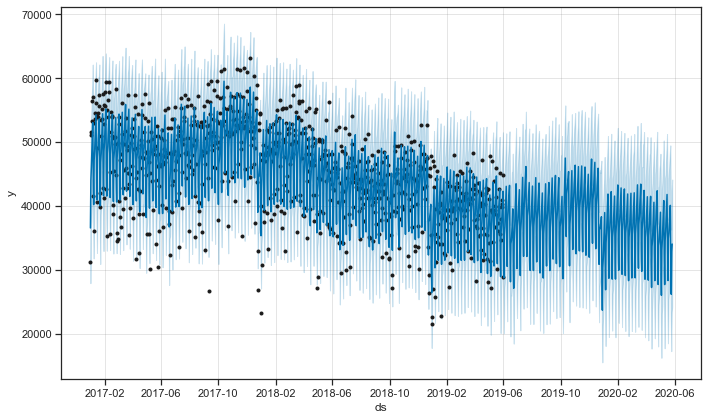

In [109]:
future = m.make_future_dataframe(periods=360, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

<Figure size 864x576 with 0 Axes>

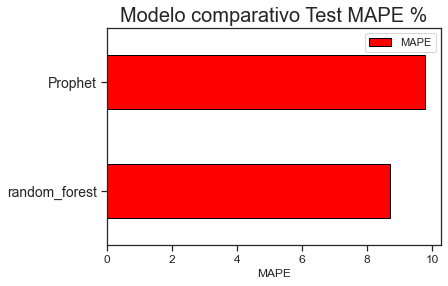

In [110]:
fig=plt.figure(figsize=(12,8))

model_comparison = pd.DataFrame({'model': ['random_forest','Prophet',
                                                                            ],
                                 'MAPE': [MAPE_test_R,MAPE_test_P, 
                                         ]})

model_comparison.sort_values('MAPE', ascending = True).plot(x = 'model', y = 'MAPE', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('MAPE'); plt.xticks(size = 12)
plt.title('Modelo comparativo Test MAPE %', size = 20);

fig.autofmt_xdate()
fig.autofmt_xdate()
fig.tight_layout()

#print('% de mejora entre modelos:Arbol de decisión vs Random Forest')
#mejora(MAPE_test_R,MAPE_test_P)


De primera instancia podemos ver que nuestro modelo random_forest tiene mejor performance, sin embargo analizaremos caso a caso para ver que tanto caen en overfiting nuestros modelos.

<Figure size 864x576 with 0 Axes>

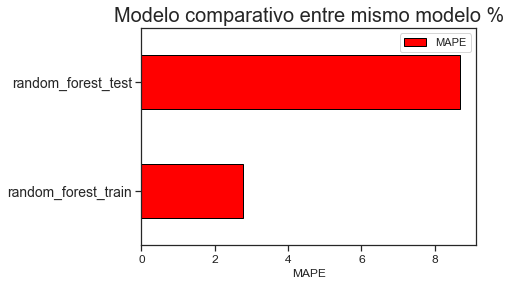

In [111]:
fig=plt.figure(figsize=(12,8))

model_comparison = pd.DataFrame({'model': ['random_forest_train','random_forest_test',
                                                                            ],
                                 'MAPE': [MAPE_train_R,MAPE_test_R, 
                                         ]})

model_comparison.sort_values('MAPE', ascending = True).plot(x = 'model', y = 'MAPE', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('MAPE'); plt.xticks(size = 12)
plt.title('Modelo comparativo entre mismo modelo %', size = 20);

fig.autofmt_xdate()
fig.autofmt_xdate()
fig.tight_layout()

#print('% de mejora entre modelos:Arbol de decisión vs Random Forest')
#mejora(MAPE_test_R,MAPE_test_P)


si observamos detenidamente es claro que nuestro modelo que aunque falla menos, tiende a hacer bastante overfiting, ya que esta memorizando demasiado nuestros datos, procedemos a ver la proporción en nuestro segundo modelo

<Figure size 864x576 with 0 Axes>

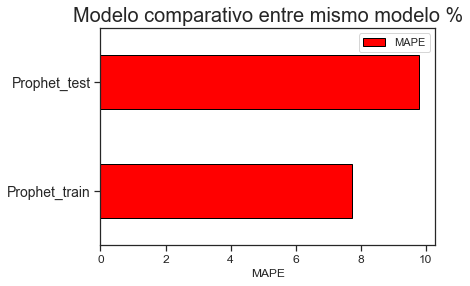

In [112]:
fig=plt.figure(figsize=(12,8))

model_comparison = pd.DataFrame({'model': ['Prophet_train','Prophet_test',
                                                                            ],
                                 'MAPE': [MAPE_train_P,MAPE_test_P, 
                                         ]})

model_comparison.sort_values('MAPE', ascending = True).plot(x = 'model', y = 'MAPE', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('MAPE'); plt.xticks(size = 12)
plt.title('Modelo comparativo entre mismo modelo %', size = 20);

fig.autofmt_xdate()
fig.autofmt_xdate()
fig.tight_layout()

#print('% de mejora entre modelos:Arbol de decisión vs Random Forest')
#mejora(MAPE_test_R,MAPE_test_P)


Como podemos ver, nuestro modelo prophet aunque tiene más error en test, tiende a hacer overfiting en menor proporción, es por ello que elegimos nuestro segundo modelo para hacer nuestros pronosticos y de esta manera tener mayor acierto en valores nuevos.


<font align='/center;' color='dark' face='arial' size=5> Añadiendo más variables a nuestro modelo.</font>

In [113]:
m = Prophet(seasonality_mode=r['seasonality_mode'],
            changepoint_prior_scale=r['changepoint_prior_scale'],interval_width=0.95, 
            yearly_seasonality=30,holidays=holidays,daily_seasonality=True,n_changepoints=r['n_changepoints'],
            weekly_seasonality=True,holidays_prior_scale=r['holidays_prior_scale'])
#m = Prophet(interval_width=0.95,holidays=holidays,daily_seasonality=True,weekly_seasonality=True,holidays_prior_scale=20)
#m.add_seasonality(name='quarterly',period=365.25 / 4 ,fourier_order=15)
m.add_seasonality (name = 'year', period = 50, fourier_order = 3, prior_scale = 0.002)
m.add_regressor('T_liviano')
m.fit(pjme_train)

In [114]:
pjme_train_fcst = m.predict(pjme_train)
pjme_test_fcst = m.predict(pjme_test)

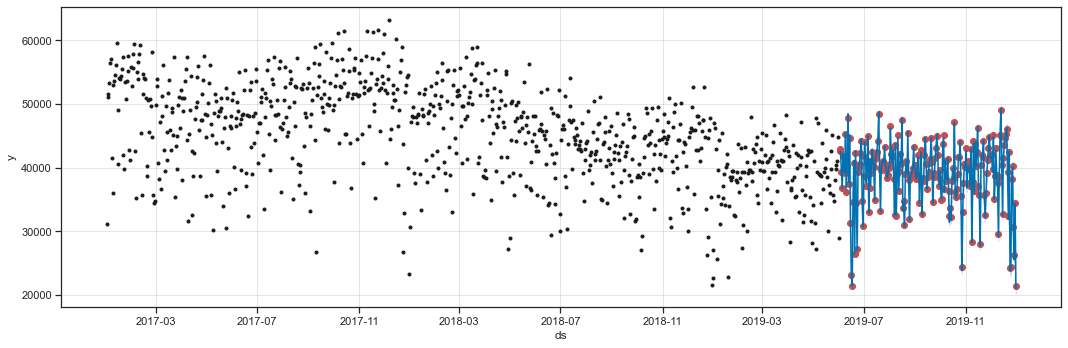

In [115]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.ds, pjme_test['cantidad_pasos'], color='r')
fig = m.plot(pjme_test_fcst, ax=ax)

In [116]:
MAPE_train_P = mean_absolute_percentage_error(pjme_train.cantidad_pasos,pjme_train_fcst.yhat)
MAPE_test_P = mean_absolute_percentage_error(pjme_test.cantidad_pasos,pjme_test_fcst.yhat)
print(f'errror en train: {MAPE_train_P}')
print(f'errror en test: {MAPE_test_P}')


errror en train: 0.266685037222345
errror en test: 0.6144879113126899


<font align='/center;' color='dark' face='arial' size=5> Conclusiones generales.</font>

<div style="text-align: justify">Para concluir nuestro proyecto, daremos paso a responder algunas preguntas,¿Que información esta usando nuestro modelo para predecir?, Nuestro modelo elegido es el algoritmo de prophet, consideramos que los datos o la forma en como predice sus valores, esta correlacionado con los mismos datos de entrada, es decir consideramos que hace un análisis ventanas de tiempo por ventanas de tiempo y busca patrones entre ellos, para una vez encontrado esos patrones poder predecir valores nuevos y desconocidos, si bien es cierto que no siempre es facil llegar a buenas predcciones, parece ser que el algoritmo predice bastante bien. ¿Como funciona el modelo para la predicción de 2020?, Si bien se construyo el modelo para realizar predicciones cercanas con cierto grado de confianza ,sin embargo este año ha sido para la historia, ya que considero que ninguna estimación podra llegar a cierto grado de certidumbre debido al problema que estamos viviendo actualmente con la pandemia, es bueno mencionar que nuestro error inicial ronda en 9% de error, es claro ver que ningún algoritmo tiene el poder de tener un 100% de certeza, y es claro que a medida que el modelo intenta predecir a futuro mas es el porcentaje de erorr que puede tener, nuestro modelo en nuestro cross validation nos marca una oscilación de entre un 9%-20% de erorr, y a medida que aumenta la venta de predicción mas se acerca a nuestro error maximo.</div>

<div style="text-align: justify">De igual manera, el agregar variables a nuestro modelo consideramos que tiende a hacer overfiting de una manera exagerada, ya que tiene a aprenderse todos los valores y como podemos ver en la gráfica acerta a practicamente todos los valores, teniendo valores tan bajos de error en test y train, y consideramos que no logra una correcta generalización de nuevos valores.</div>

<div style="text-align: justify">Como conclusión general podemos resumir que nuestro modelo prophet es un algoritmo potente y con varias ventajas sobre random forest, sin embargo consideramos que no es nada despreciable los resultados de nuestro modelo benchmark con random forest, no esta demas mencionar que al final del día nuestras predicciones siempre pueden errar, y muestra de ello considero todas las predicciones forecasting de 2020 tuvieron los outliers más grandes inesperados por todos los algoritmos, si bien es importante acortar la brecha entre predicciones y valores reales, considero que la mejor ventaja es estar al pendiente de nuestro modelo y lograr reacomodar decisiones, y saber mover sobre la marcha todo lo necesario para poder llevar a cabo las predicciones, y esto es hablando en general y no en particular sobre nuestro proyecto de la autopista. Es importante siempre contar con nuevos datos actualizados que nos puedan apoyar juntos con los algoritmos, mejores resultados y a su vez mejores decisiones.